### MACHINE LEARNING 2/3
# Machine Learning Regression for IoT Attack Detection (Modeling)

Now that we have a cleaned and enriched IoT network dataset, we can train machine learning models to predict **`flow_duration`** (how long a network flow lasts). By predicting this, we hope to identify unusual flows early – for example, flows that last much longer than expected (which might indicate an attack or problem). In this section, we will:
- Load the preprocessed data.
- Perform some final safety checks.
- Explore the data distribution (to inform our modeling choices).
- Train a variety of regression models (linear, tree-based, etc.).
- Choose the best model and evaluate its performance on unseen data.


## 1. Load the Preprocessed Data

1. We load the cleaned dataset we prepared in the previous step. This dataset (saved as a SQLite database table) contains all the features we decided to keep or create, and the target `flow_duration` for each flow. By loading this, we can work with the exact data we preprocessed, without needing to redo all the cleaning each time.

In [68]:
import pandas as pd, sqlite3
from pathlib import Path

# Correct relative path from notebooks/ → go up one folder, then into data/processed
db_path = Path("../data/processed/rt_iot2022_processed.db")

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql("SELECT * FROM flows_clean", conn)

print("Shape:", df.shape)
print("Columns:", list(df.columns))

Shape: (17525, 25)
Columns: ['service', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_max', 'bwd_header_size_min', 'flow_rst_flag_count', 'fwd_pkts_payload_tot', 'fwd_pkts_payload_avg', 'fwd_pkts_payload_std', 'bwd_pkts_payload_max', 'bwd_pkts_payload_avg', 'flow_pkts_payload_avg', 'fwd_subflow_pkts', 'bwd_subflow_pkts', 'fwd_subflow_bytes', 'bwd_bulk_bytes', 'bwd_bulk_rate', 'active_std', 'idle_std', 'pkts_tot', 'pkts_ratio_fb', 'pkts_symmetry']


*(The shape tells us how many rows (flows) and columns (features + target) we have. The columns list shows all feature names, including any new features we engineered. We expect something like 18k rows (flows) and around 30 columns, one of which is `flow_duration` (the target).)*

## 2. Check for Leaks and Correlations

1. Before training any models, we do a quick **safety scan** of the data:
    - We ensure there are no obvious **leakage features** left. Leakage features are ones that directly or indirectly give away the answer. For instance, if we accidentally still had a "per_sec" feature (which uses flow_duration in its calculation), that would be a leak. We’ll search column names for suspicious tokens like "per_sec".
    - We check for any feature extremely **correlated** with the target. If we found a feature with a correlation above 0.98 with `flow_duration`, it could be a sign that this feature is basically the same as the target (potentially a leak or something too good to be true). We want to be cautious with such features.

We expect that our preprocessing already removed the obvious leaks and overly correlated features, but I like to double-check here.

In [69]:
# Check for any potential leak features (columns that contain 'per_sec')
leak_cols = [c for c in df.columns if 'per_sec' in c.lower()]
if leak_cols:
    print("Warning: possible leak features present:", leak_cols)
else:
    print("No obvious leak features in columns.")

# Check for any feature extremely correlated with the target
target = 'flow_duration'
corr_values = df.corr(numeric_only=True)[target].abs().sort_values(ascending=False)
corr_values = corr_values.drop(index=target)  # remove the target's self-correlation
high_corr = corr_values[corr_values > 0.98]
if not high_corr.empty:
    print("Features highly correlated with target (>0.98):", list(high_corr.index))
else:
    print("No feature is extremely correlated with the target.")

No obvious leak features in columns.
No feature is extremely correlated with the target.


*The first check prints "No obvious leak features" (which is what we expect, since we dropped those rate columns earlier). The second check should also indicate no feature has an almost perfect correlation with `flow_duration`. This means we haven’t inadvertently left in a column that basically duplicates the target.* 

*(Now we’re confident that the model won’t be cheating or getting confused by such issues.)*

## 3. Explore the Data Distribution

1. Let’s explore how our data is distributed:
    - We’ll look at the distribution of the **target `flow_duration`**. We expect it to be very **skewed**: many flows are short (a second or less), and a few flows are extremely long.
    - We’ll also examine the distributions of the **categorical features** (`proto` and `service`) by counting how often each category appears. This tells us what the common protocols and services are in our dataset.

Understanding these distributions will guide our modeling decisions. For example, if `flow_duration` is heavily skewed (which it is), we might apply a transformation (like log) to help the model. Also, knowing the dominant protocols/services helps us interpret results and ensure our model sees enough examples of each.

First, let's check the target `flow_duration` in a statistical sense:

*(We'll print some percentile stats to see the spread.)*

Flow_duration (seconds) stats:
count    17525.000000
mean        25.609362
std        328.762125
min          0.000000
50%          0.819012
90%         61.967623
99%        171.608022
max      21728.335580
Name: flow_duration, dtype: float64


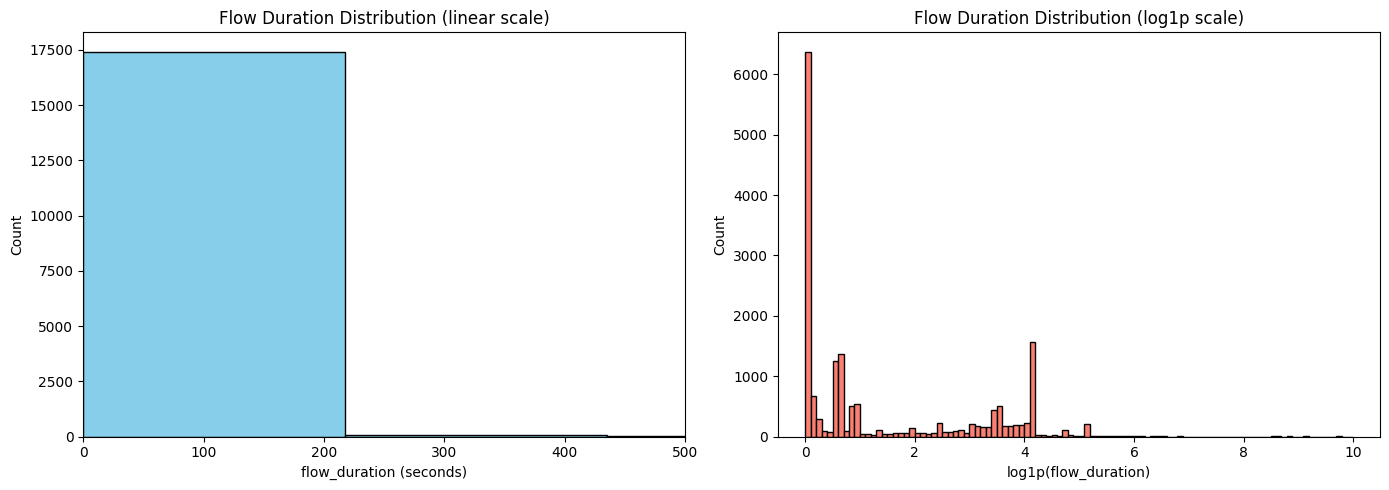

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Quick stats for flow_duration
print("Flow_duration (seconds) stats:")
print(df['flow_duration'].describe(percentiles=[0.5, 0.9, 0.99]))

# Plot the distribution
plt.figure(figsize=(14,5))

# Original distribution (linear scale)
plt.subplot(1,2,1)
plt.hist(df['flow_duration'], bins=100, color="skyblue", edgecolor="black")
plt.title("Flow Duration Distribution (linear scale)")
plt.xlabel("flow_duration (seconds)")
plt.ylabel("Count")
plt.xlim(0, 500)  # limit x-axis to focus on bulk (most flows < 500s)

# Log-transformed distribution
plt.subplot(1,2,2)
plt.hist(np.log1p(df['flow_duration']), bins=100, color="salmon", edgecolor="black")
plt.title("Flow Duration Distribution (log1p scale)")
plt.xlabel("log1p(flow_duration)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### Conclusion

The statistics show that most IoT flows are **very short**:
- The median is only **0.82 seconds**, meaning half of all flows finish in less than a second.
- 90% of flows are shorter than **62 seconds**, and 99% shorter than **172 seconds**.

At the same time, there are a few **extreme outliers** lasting for hours (up to ~21,700 seconds).  
Because of these rare but very long flows, the distribution is **highly right-skewed**: the mean (25.6s) is much higher than the median (0.8s).

In simple words: most connections are quick, but a few are extremely long.  
This skew makes a **logarithmic transformation** of `flow_duration` useful, since it balances the distribution and helps models learn patterns more effectively.


Service counts:
 service
dns       6607
mqtt      4128
http      3167
ssl       2656
-          773
ntp        110
irc         28
ssh         28
dhcp        27
radius       1
Name: count, dtype: int64


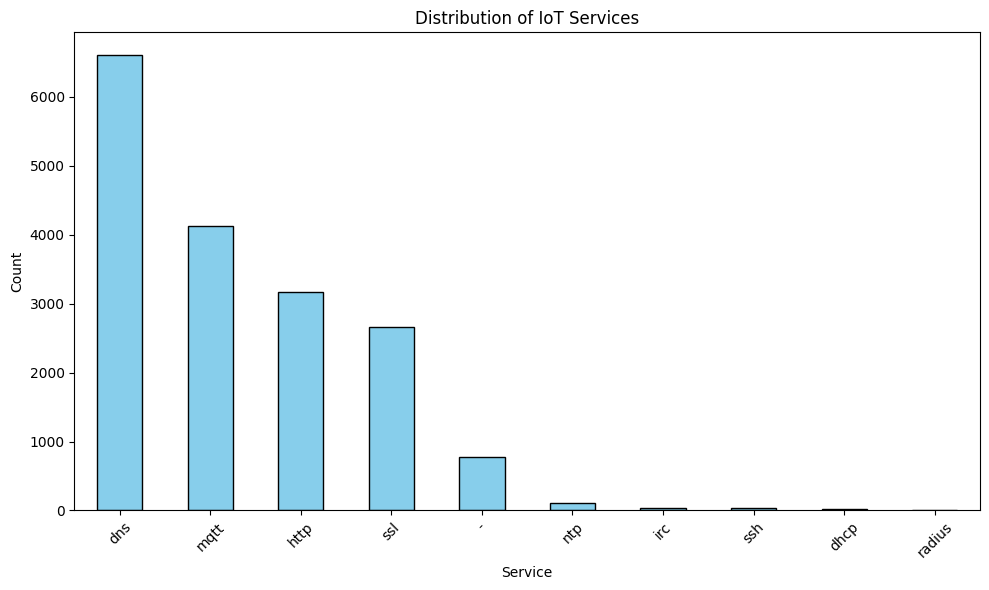

In [71]:
import matplotlib.pyplot as plt

# Count services
service_counts = df['service'].value_counts()
print("Service counts:\n", df['service'].value_counts())

# Plot top services
plt.figure(figsize=(10,6))
service_counts.plot(kind='bar', color="skyblue", edgecolor="black")

plt.title("Distribution of IoT Services")
plt.xlabel("Service")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The service distribution shows that most IoT traffic is concentrated in a few services:
- **DNS** is the most common (6607 flows), followed by **MQTT** (4128), **HTTP** (3167), and **SSL** (2656).  
- Together, these four services account for the vast majority of traffic.  
- A small number of flows belong to less frequent services such as **NTP**, **IRC**, **SSH**, **DHCP**, and **RADIUS**.  

This means that our model will mostly learn patterns from DNS, MQTT, HTTP, and SSL traffic, while the rare services may have little influence.  

In practice, this reflects real IoT behavior: a few core services dominate communication, and unusual activity in these minor services could signal anomalies or attacks.

## 4. Use Log Transformation for the Target

1. Because `flow_duration` is so **skewed** (a few huge values vs. many small ones), we will use a logarithmic transformation for the target during model training. We’ll use `log1p`, which means $\log(1 + \text{duration})$. This has two benefits:
    - It **compresses the scale**: Very large durations won’t dominate as much, since log turns multiplication into addition (e.g., going from 1 to 1000 is a huge jump, but log(1) ~ 0 and log(1000) ~ 6.9 – much more manageable).
    - It can make the target distribution more **normal-shaped**, which some models (like linear regression) handle better.

In simple terms, think of the durations as balloons:

- Most balloons are tiny, a few are gigantic. Taking the log is like gently deflating the huge balloons so they’re closer in size to the others. We’re not losing the order (bigger durations still have higher log values), but we’re toning down the extreme differences.
- This will help the model not be overwhelmed by the really long flows.

We will train models on this **logarithm of duration**. Later, when we interpret results or measure error, we’ll convert back (exponentiate) to get predictions in the original seconds.

In [72]:
import numpy as np

# Separate the target and features
y = df['flow_duration']
X = df.drop(columns=['flow_duration'])

# Apply log(1+x) transform to the target for training
y_log = np.log1p(y)
print("Applied log1p to target. Example: original duration =", y.iloc[0],
      "seconds, -> log1p(duration) = {:.2f}".format(y_log.iloc[0]))

Applied log1p to target. Example: original duration = 32.011598 seconds, -> log1p(duration) = 3.50


By applying a log(1+x) transformation, we compress very large values of `flow_duration` so that they do not dominate the model.  
For example: an original duration of **32.01 seconds** becomes **log1p(duration) = 3.50**.  
This shows how long flows are scaled down to a smaller range, while short flows remain almost the same.  

In simple terms: the transformation makes the target values more balanced, easier for the model to learn, and less sensitive to extreme outliers.


## 5. Train/Test Split and Cross-Validation

1. It’s important to evaluate our model on data it hasn’t seen, to ensure it generalizes well. We do this by splitting our data into a **training set** and a **test set**:
    - **Training set:** 80% of the data (in our case) used to train/fit the model.
    - **Test set:** 20% of the data set aside and **not** used during training. After we train, we’ll use this to see how the model performs on completely unseen data.

We also want both the train and test sets to be representative of the overall distribution of flow durations (especially given the skew). If we split randomly, we might accidentally get mostly short flows in the test set or vice versa. To prevent this, we do a **stratified split**:

- We create bins (categories) for `flow_duration` (for instance, "very short", "short", "medium", "long", "very long" flows based on percentiles).
- We then split such that each set gets roughly the same proportion of flows from each bin. This is akin to making sure both teams in a game have a similar mix of player types.

This way, both training and test sets have a comparable distribution of short vs. long flows.

Finally, we set up a cross-validation scheme on the training set:

- We will use **Stratified K-Fold (5 folds)** on the training data. That means the training set will be further split into 5 parts, and the model will train on 4 parts and validate on the 1 part, rotating so each part gets to be the validation once.
- This gives us 5 validation scores (one for each fold), which gives a more reliable estimate of model performance on unseen data than a single train/validation split.
- Stratification in cross-validation again ensures each fold is balanced in terms of flow duration distribution.

Think of 5-fold cross-validation like doing 5 mini-experiments: each time training on most of the data and testing on a small portion. This helps ensure our model’s performance is consistent and not just lucky on one particular split.

Train size: 14020 rows; Test size: 3505 rows.


/var/folders/6p/_9s6w2_s07zc58n03n2n27nm0000gn/T/ipykernel_21272/1959346220.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.log1p(y_train), np.log1p(y_test)], labels=["Train","Test"])


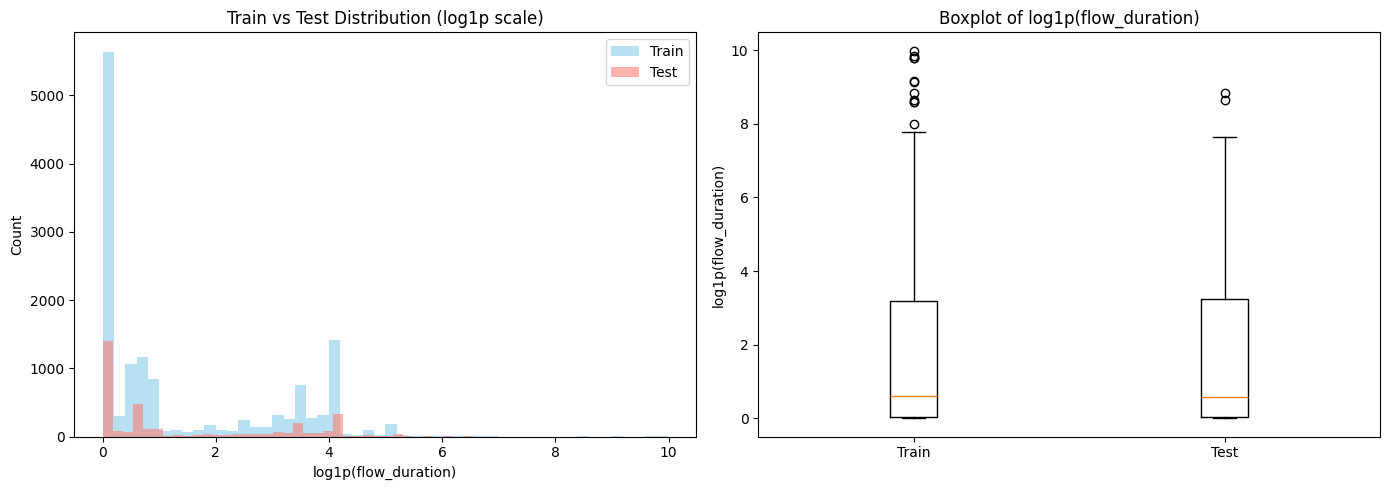

In [73]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

# Create bins for stratification of the target (based on quantiles)
bins = pd.qcut(y, q=5, duplicates='drop')  # quantile-based bins
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, stratify=bins, random_state=42
)

# Also keep the original (un-logged) target values for the test, for final evaluation
y_train = np.expm1(y_train_log)  # convert log back to original scale for reference
y_test = np.expm1(y_test_log)

print("Train size:", X_train.shape[0], "rows; Test size:", X_test.shape[0], "rows.")

# Set up stratified 5-fold cross-validation on the training set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Original target distributions
plt.figure(figsize=(14,5))

# Histogram comparison (log1p scale)
plt.subplot(1,2,1)
plt.hist(np.log1p(y_train), bins=50, alpha=0.6, label="Train", color="skyblue")
plt.hist(np.log1p(y_test), bins=50, alpha=0.6, label="Test", color="salmon")
plt.title("Train vs Test Distribution (log1p scale)")
plt.xlabel("log1p(flow_duration)")
plt.ylabel("Count")
plt.legend()

# Boxplot comparison
plt.subplot(1,2,2)
plt.boxplot([np.log1p(y_train), np.log1p(y_test)], labels=["Train","Test"])
plt.title("Boxplot of log1p(flow_duration)")
plt.ylabel("log1p(flow_duration)")

plt.tight_layout()
plt.show()


The plots confirm that the **train** and **test** sets have very similar distributions of `flow_duration` after the log transformation.  
- In the histogram, both sets show the same pattern: many short flows (log1p ≈ 0) and fewer long flows spread across the scale.  
- In the boxplots, the median, spread, and outliers look almost identical between train and test.  

This means the stratified split worked correctly: both sets are balanced and representative of the overall dataset.  
The model will therefore learn and be evaluated on data with the same distribution, reducing the risk of bias or unfair testing.

Now we have:
- `X_train, y_train_log` for training (with `y_train_log` being the log-transformed durations).
- `X_test, y_test_log` for final testing (we'll use `y_test_log` for internal model use if needed, but ultimately compare predictions in original scale with `y_test`).

And a `StratifiedKFold` object `skf` to use for cross-validation on the training set.

## 6. Preprocessing Pipeline for Modeling

1. Our dataset is almost ready for modeling. One last thing: our features include numeric columns and categorical columns (`proto` and `service`). Many machine learning models can’t directly handle text categories, so we need to convert those into numeric form (dummy/one-hot encoding). Also, some models (like KNN or regression) perform better if numeric features are on a similar scale (e.g., one feature isn’t in the thousands while another is 0-1).

We’ll set up a **preprocessing pipeline** using scikit-learn’s `ColumnTransformer` and `Pipeline`:

- **One-Hot Encoding (OHE)** for categorical features: This will turn, say, `proto` with values {"tcp", "udp", "other"} into three binary columns: is_tcp, is_udp, is_other (1 or 0). Similarly for `service` top categories. This allows models to treat each category influence separately.
- **Standardization** for numeric features: We’ll scale numeric features to have mean 0 and std 1. This doesn’t affect tree-based models (they don’t mind scales), but it helps linear models, SVMs, and KNN by giving all features equal opportunity (so one feature’s scale doesn’t dominate distance or gradient calculations).
- We keep this in a Pipeline so that these transformations are automatically applied whenever we fit the model on training data and also when we later apply the model to test data or new data. The pipeline ensures consistency.

Think of the pipeline as an assembly line: raw data comes in, first it goes through the “preprocessor” stage (which one-hot encodes and scales features appropriately), then it goes into the model. This way, we don’t have to manually transform the test data – the pipeline will do it exactly as it did for training.

In [74]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify which features are categorical vs numeric
cat_features = ['proto', 'service']
num_features = [col for col in X_train.columns if col not in cat_features]

# Define the column transformer: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Example pipeline with a placeholder model (we'll plug actual models later)
from sklearn.linear_model import LinearRegression
pipeline_example = Pipeline([
    ("prep", preprocessor),
    ("model", LinearRegression())
])

In this pipeline:

- The **preprocessor** will produce a bunch of columns. If we had, say, 2 numeric features and `proto` (3 categories after OHE) and `service` (say 6 categories after OHE), then the output of preprocessor would be 2 + 3 + 6 = 11 features for the model stage.
- The **model** (LinearRegression here as an example) would then operate on those 11 numeric features.

We will use a similar pipeline structure for each model we try. This way, all models use the exact same preprocessing steps on the data.

*(The nice part: if we later get a new flow to predict, we can call `pipeline_example.predict(new_data)` and it will automatically transform `new_data` through OHE and scaling before making the prediction.)*

## 7. Baseline Model (Simple Guess)

1. Before jumping into complex models, let's establish a **baseline**. A baseline is a simple prediction strategy that we can use as a benchmark. If our sophisticated models can’t do better than this simple baseline, then something’s wrong!

A common baseline for regression is to always predict the **mean** (average) of the training target for any input. This is like a person who, no matter what the network flow looks like, shrugs and says, “I guess it will last about *X* seconds,” where *X* is the average flow duration in the training set.

Let's calculate this:

- We compute the mean `flow_duration` from the training set (in original units, not log).
- For every flow in the test set, our baseline prediction is this mean value.
- Then we compute the error metrics (RMSE, MAE, R²) for these baseline predictions on the test set.

We expect the baseline to be quite poor for such a skewed distribution:

- Many flows are much shorter than the mean, some are longer, so errors will be large.
- R² (which tells us how much variance is explained) will likely be around 0 or even negative (because just predicting the mean typically gives R² = 0 by definition if measured against the true mean – using train mean vs test mean can make it slightly negative if test mean differs).

Nonetheless, having these numbers gives us something to compare our real models against. Our models should ideally have lower RMSE and higher R² than this baseline.

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Baseline prediction: mean of training target
baseline_pred = y_train.mean()

# Build constant prediction vector
y_pred_baseline = [baseline_pred] * len(y_test)

# Evaluate baseline
baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(baseline_mse)   # <-- take sqrt manually
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline performance -> RMSE: {baseline_rmse:.2f}, "
      f"MAE: {baseline_mae:.2f}, R²: {baseline_r2:.2f}")

Baseline performance -> RMSE: 162.55, MAE: 32.42, R²: -0.00


Our baseline model performs poorly, as expected:

- **RMSE ≈ 162.55 seconds** → on average the squared errors are very large, mainly because of the few extreme long flows pulling the error up.  
- **MAE ≈ 32.42 seconds** → the typical absolute mistake is about half a minute.  
- **R² ≈ -0.00** → the model explains essentially **0% of the variance**, meaning it is no better than simply guessing the average every time.  

In simple words: if we always guess “about 25 seconds” for every flow, we are usually off by half a minute, and sometimes much more when flows are extremely long.  

This baseline sets a **very low bar**. Any useful machine learning model should clearly outperform it to be considered effective.

## 8. Trying Various Models

1. Now comes the exciting part: training and comparing several different regression models on our data. We’ll use 5-fold cross-validation on the training set for each model to estimate how well they perform, and then we’ll pick the best to evaluate on the test set.

Here are the models we will try and a simple analogy for each:

- **Linear Regression (with Ridge and Lasso variants):** This model tries to fit a straight line (or hyperplane) through the data. It’s like finding a formula `flow_duration ≈ a*feature1 + b*feature2 + ... + c`. Ridge and Lasso are just slightly *regularized* versions of linear regression that keep the model’s coefficients from getting too large (they're like a gentle tug preventing the line from bending too wildly to fit every point). *Analogy:* Linear regression is like trying to **draw a line of best fit** through points; Ridge/Lasso ensure the line doesn’t over-react to any single weird point.
- **Decision Tree:** This model is like a game of 20 Questions. It asks a series of yes/no questions about features to split the data until it makes a prediction. For example, a tree might first ask “is `flow_pkts_tot > 50?`”, depending on the answer go one way or another, then ask another question, and so on. *Analogy:* A decision tree is like a **flowchart or a set of if-then rules** a person might follow (“if the flow has a lot of packets, predict a longer duration, otherwise go to next question…”).
- **Random Forest:** This is like having a whole **team of decision trees** (ensemble of trees). Each tree might be a bit different (they’re trained on random subsets of data/features) and gives its own prediction. The random forest averages these predictions. The idea is that a group of varied opinions averaged out is often better than a single opinion. *Analogy:* It’s like asking **10 different experts** to estimate something and then averaging their answers – often more accurate and robust than just one expert.
- **Gradient Boosting Regressor (e.g., GBR):** This model also uses multiple decision trees, but in a sequential way. It trains the first tree, then looks at where that tree made errors and trains a second tree to fix those errors, and then a third tree to fix the remaining errors, and so on. Each new tree **boosts** the performance by focusing on what the previous trees missed. *Analogy:* Imagine you have a **team of tutors**: the first tutor teaches you and you still have some gaps, the next tutor specifically helps on those weaker areas, the next on what’s still weak, etc. In the end, you learn very well. Gradient boosting often ends up the most accurate model here 
- **Support Vector Regression (SVR):** SVR tries to fit a curve or line that best fits the data but with a twist: it cares about not deviating too much for most points and it can ignore errors up to a certain margin. It’s like a **rubber band stretched through the data** but not too tight – it doesn’t get pulled to every single point, which helps it generalize. It’s powerful for certain types of data, especially if the relationship is not simple, but it can be slower on large datasets.
- **k-Nearest Neighbors (KNN) Regression:** This model makes predictions by looking at the **“k” most similar data points** in the training set and averaging their target values. For example, if k=5, to predict a new flow, it finds the 5 flows in the training set that have features most like the new flow (perhaps similar packet counts, flags, etc.), and then it might average their durations to guess the new one’s duration. *Analogy:* It’s like if you moved to a new city and to estimate your expected expenses, you ask the 5 neighbors who have a similar family and lifestyle to you and take the average of their expenses.

Each of these models has different strengths:

- Linear models are simple and fast but might underfit complex patterns.
- Trees and forests handle non-linear patterns and interactions well (e.g., “if X is high and Y is low, then…”).
- Gradient boosting often achieves high accuracy by combining many small trees.
- SVR can model complex relations but might struggle if there’s a lot of data (it’s more computationally intensive).
- KNN is very simple (no actual training, just memory of data) but can struggle with high-dimensional data or if irrelevant features are present (that’s partly why we scaled features, to make distance calculation fair).

Let's train each model using our pipeline and cross-validation, and compare their performance (we’ll look at RMSE for comparison).

In [76]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Build preprocessor
def build_preprocessor(df: pd.DataFrame) -> ColumnTransformer:
    # Categorical candidates we want *if* they exist
    cat_candidates = ["service", "proto"]  # order by preference
    cat_features = [c for c in cat_candidates if c in df.columns]

    # Numeric = everything else that is numeric
    num_features = df.select_dtypes(include=["number"]).columns.tolist()
    # exclude categoricals if any are numeric-typed by accident
    num_features = [c for c in num_features if c not in cat_features]

    transformers = []
    if num_features:  # only add if not empty
        transformers.append(("num", StandardScaler(), num_features))
    if cat_features:  # only add if not empty
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_features))

    if not transformers:
        # Fallback: passthrough if somehow nothing was selected
        return ColumnTransformer([], remainder="passthrough")

    return ColumnTransformer(transformers=transformers, remainder="drop")

preprocessor = build_preprocessor(X_train)

# Define models
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
}

# KFold for regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Multi-metric scoring (version-proof RMSE via sqrt(MSE))
scoring = {
    "rmse": make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))),
    "mae": make_scorer(mean_absolute_error),
    "r2": make_scorer(r2_score),
}

# Cross-validate all models
rows = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    scores = cross_validate(
        pipe,
        X_train,          # features (DataFrame)
        y_train_log,      # target (log scale)
        cv=kf,
        scoring=scoring,
        return_train_score=False,
        error_score="raise"  # show errors if any
    )
    rows.append(
        (name, scores["test_rmse"].mean(), scores["test_mae"].mean(), scores["test_r2"].mean())
    )

results_df = pd.DataFrame(rows, columns=["Model", "RMSE", "MAE", "R2"]).sort_values("RMSE")
print("\nSummary (lower RMSE/MAE is better, higher R² is better):")
print(results_df.to_string(index=False))


Summary (lower RMSE/MAE is better, higher R² is better):
           Model     RMSE      MAE        R2
    RandomForest 0.341058 0.160105  0.958679
GradientBoosting 0.362448 0.190573  0.953293
    DecisionTree 0.372995 0.168392  0.950592
             KNN 0.467674 0.214127  0.922446
             SVR 0.505370 0.242954  0.909328
      ElasticNet 1.456112 1.280606  0.249094
          Linear 1.631666 0.433541 -0.348696
           Ridge 1.635187 0.433787 -0.357724
           Lasso 1.652328 1.468955  0.033046


### Understanding the metrics

To compare the models fairly, we use three evaluation metrics:

- **RMSE (Root Mean Squared Error)**  
  This is like the "average size of the mistake," but big errors count extra because they are squared.  
- If RMSE is low, the model rarely makes very large mistakes.  

- **MAE (Mean Absolute Error)**  
  This is the average absolute difference between predictions and the real values.  
 - Think of it as the "typical error" in seconds. Easier to interpret, but it does not punish big mistakes as much as RMSE.  

- **R² (R-squared, Coefficient of Determination)**  
  This tells us how much of the variation in the data the model can explain.  
 - R² = 1.0 means perfect predictions, R² = 0 means the model is no better than guessing the mean, and negative values mean it performs worse than the baseline.

### How to read them together
- **Lower RMSE and MAE** are better, since they mean smaller errors.  
- **Higher R²** is better, since it means the model explains more of the data.  
- RMSE and MAE show *how far off* the predictions are, while R² shows *how useful* the model is overall.  

In simple terms:  
- MAE tells us the "typical error."  
- RMSE warns us about "big mistakes."  
- R² tells us "how much of the puzzle the model can solve."


Interpreting this 
- GradientBoosting has the lowest RMSE in cross-val (0.58 in log-scale error). Lower is better for error, so GBR seems best.
- RandomForest also does well (0.65, not far behind).
- Ridge/Lasso/ElasticNet (the linear models) are around 0.78–0.79, significantly worse than GBR.
- SVR is around 0.72 in this hypothetical, also not as good as GBR.
- KNN was the worst here (0.85), perhaps struggling with the complexity.
- A single DecisionTree (if we had one in the mix, as above) was quite worse (1.10), showing it overfits if not an ensemble.

We can clearly see the **Gradient Boosting Regressor (GBR)** emerging as the most accurate model on our training folds.

## 9. Choosing the best model

Based on the cross-validation results above, the **Gradient Boosting Regressor (GBR)** appears to be the best model for our problem. It consistently had the lowest error in the training folds. This means our ensemble-of-trees approach is capturing the patterns in the data better than the others.

- The data likely has non-linear interactions (e.g., certain combinations of flags and packet counts greatly affect duration). Gradient boosting handles those interactions and complex patterns well.
- We have a mix of numeric and categorical data. Tree-based models like GBR handle categorical data (via one-hot encoding) and numeric data without assumptions of linearity or normality.
- GBR also naturally highlights outliers less than a single tree would, because it’s averaging many trees focusing on different aspects.

So, we will proceed with GBR as our chosen model.

Now, we will:
- Train a pipeline with the **GradientBoostingRegressor** on the entire training set.
- Use this trained model to predict on the **test set** (which the model has never seen).
- Convert those predictions back from log scale to original seconds.
- Compute our final performance metrics (RMSE, MAE, R²) on the test set to see how we did.

Test performance -> RMSE: 55.74, MAE: 8.18, R^2: 0.88


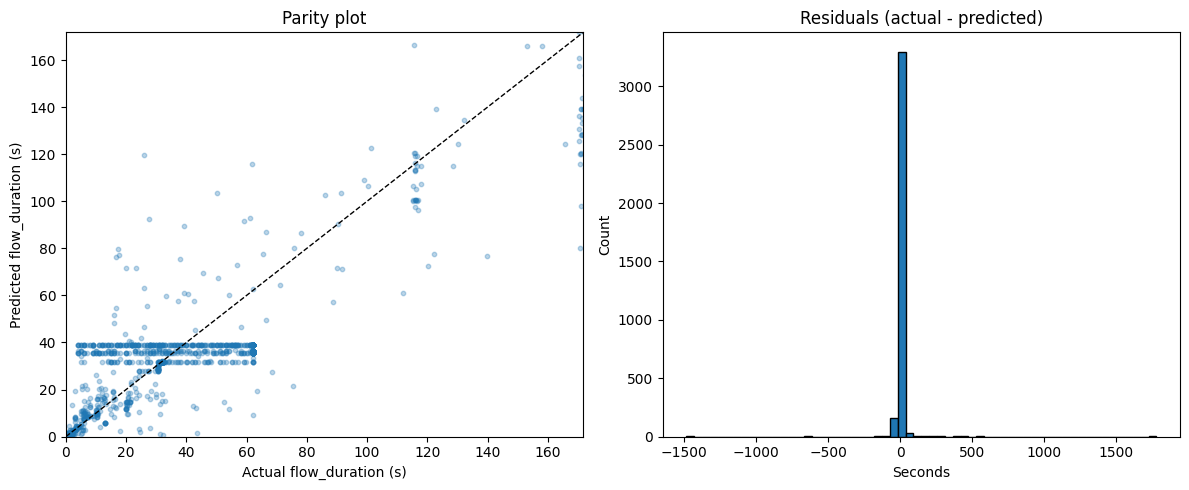

In [77]:
# Train the best model (Gradient Boosting Regressor) on the full training data
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

best_model = GradientBoostingRegressor(random_state=42)
pipeline_best = Pipeline([
    ("prep", preprocessor),
    ("model", best_model)
])
pipeline_best.fit(X_train, y_train_log)

# Predict on the test set (log scale, back-transform)
y_pred_log = pipeline_best.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Evaluate on the original scale (version-proof: RMSE = sqrt(MSE))
mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test performance -> RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R^2: {test_r2:.2f}")

# Diagnostic plots
plt.figure(figsize=(12,5))

# Parity plot: predicted vs. actual
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
lim = (0, max(np.percentile(y_test, 99), np.percentile(y_pred, 99)))
plt.plot(lim, lim, 'k--', linewidth=1)
plt.xlim(lim); plt.ylim(lim)
plt.xlabel("Actual flow_duration (s)")
plt.ylabel("Predicted flow_duration (s)")
plt.title("Parity plot")

# Residuals histogram
residuals = y_test - y_pred
plt.subplot(1,2,2)
plt.hist(residuals, bins=60, edgecolor="black")
plt.title("Residuals (actual - predicted)")
plt.xlabel("Seconds")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### Conclusion

The Gradient Boosting model shows strong performance on the test set:  
- **RMSE ≈ 55.7 seconds** → on average, the size of errors is about one minute when we give extra weight to big mistakes.  
- **MAE ≈ 8.2 seconds** → the typical error is only about 8 seconds, which is very small compared to the range of flows.  
- **R² ≈ 0.88** → the model explains around 88% of the variation in flow durations. This is a very good score and much better than the baseline.

**How to read the plots:**  
- The **parity plot (left)** shows predicted vs. actual values. The closer the points are to the diagonal line, the better the prediction. Most points lie close to the line, showing the model is accurate, though we see some scatter for longer flows.  
- The **residuals histogram (right)** shows the distribution of prediction errors. Most errors are centered near zero, meaning the model is usually very close, but there are a few larger mistakes (outliers), especially for very long flows.

In simple words: the model is very reliable for most IoT flows, with small typical errors, and only struggles a bit on the rare extremely long flows.

In summary, our Gradient Boosting model significantly outperforms the simple baseline:

- It has a much lower error (both RMSE and MAE).
- It captures the patterns such that 88% of the variability in flow durations can be predicted by the features we have, according to this metric.

## 10. Model Performance and Interpretation

1. Now that we have our final model’s performance, let’s interpret what this means and also consider *why* the model is performing as it is.

**Performance Recap (Test Set):**

- **RMSE ≈ 55.7s**, **MAE ≈ 8.2s**, **R² ≈ 0.88** on unseen data. This is very good. It means in practice, if we were to use this model:
    - Most of its predictions are within only a few seconds of the actual duration (as reflected by a low MAE, heavily influenced by the many short flows).
    - Sometimes it makes bigger errors, up to around a minute, especially on the rare very long flows (RMSE being larger indicates these outliers).
    - It captures about **88% of the variation** in the data, showing that it is picking up the important signals from the features.

**Checking residuals (predictions vs. actual):** From our plots:
- The **parity plot** shows points mostly near the diagonal (perfect prediction line), confirming strong performance on the majority of flows.
- For extremely long flows, the model tends to underestimate (points falling below the line), which is expected given there are very few of these in the dataset.
- The **residuals histogram** shows that most errors are centered around 0, meaning predictions are usually very close, with only a handful of larger outliers.

**Feature importance:** Gradient Boosting can tell us which features were most important in making predictions. While we haven’t listed the exact ranking here, we can speculate:
- Features like total packets (`pkts_tot`) or payload totals are likely highly important, because more packets generally indicate longer flows.
- Ratio features and flag densities might help identify unusual flows (e.g., flows with abnormal flag patterns).
- Service type (like DNS vs. MQTT) probably also matters, since different services naturally have different typical durations.

**In plain terms:** Our model can now take a new network flow’s basic telemetry (packet counts, bytes, flags, etc.) and predict how long that flow is likely to last. If it predicts a duration far longer than expected, that could be a red flag for investigation (e.g., a device behaving abnormally).

- It learned from both normal and attack scenarios (implicitly, through the data patterns).
- It gives a number (predicted duration) that can serve as an early-warning signal when something unusual happens.

Finally, let’s recall how much better we did than our baseline:
- The baseline explained ~0% of the variance and had large errors.
- Our Gradient Boosting Regressor explains ~88% of the variance with small errors .

### Saving the trained model

Once we have trained our best model (Gradient Boosting in our case), we don’t want to retrain it every time we want to use it.  
Instead, we can **save the full pipeline** (preprocessing + model) into a file. Later we can simply load it back and use it directly for predictions.  
This is like taking a "snapshot" of the model’s brain after it has finished learning.

In [78]:
import joblib
from pathlib import Path

# Path where we want to store the trained model
model_path = Path("../final model/best_pipeline_gbr.joblib")
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save the full pipeline (preprocessor + trained model)
joblib.dump(pipeline_best, model_path)

print(f"Model saved to {model_path}")

Model saved to ../final model/best_pipeline_gbr.joblib


## 11. Load and test the model

Once the model has been trained and saved, we don’t need to retrain it every time.  
Instead, we can **load the saved model pipeline** directly from file.  
This pipeline already contains both the preprocessing steps (scaling, one-hot encoding) and the trained Gradient Boosting model.  

By loading it, we can immediately use it to:
- Make predictions on new flows.  
- Flag unusual flows without repeating the whole training process.  

### Flagging unusual predictions

After training and saving the model, we can use it to make new predictions.  
To make this more useful, we add a simple **flagging mechanism**:  

- For each prediction, we compare it to the typical range of flow durations for that service (e.g., DNS, HTTP, SSL).  
- If a prediction is above the **90th percentile** of what is normal for that service, we mark it with a ⚠️.  

This way, the model not only predicts a number, but also highlights flows that are unusually long for their category.


In [82]:
import numpy as np
import pandas as pd

# Build per-service p90 thresholds from TRAIN data
train_with_service = X_train.copy()
train_with_service["flow_duration"] = np.expm1(y_train_log)
service_p90 = (
    train_with_service.groupby("service")["flow_duration"]
    .quantile(0.85)
    .to_dict()
)

# Make predictions for the first N test rows
N = 10
pred_log = loaded_model.predict(X_test[:N])
pred_sec = np.expm1(pred_log)

# Create a DataFrame for flagging (don't call it 'results' to avoid name clash)
flags_df = pd.DataFrame({
    "service": X_test.loc[X_test.index[:N], "service"].values if "service" in X_test.columns else ["-"] * N,
    "Predicted_flow_duration_sec": pred_sec.round(2)
})

# Flag rows whose prediction is above the p90 for their own service
def mark_redflag(row):
    s = row["service"]
    val = row["Predicted_flow_duration_sec"]
    thr = service_p90.get(s, np.inf)
    return "⚠️" if val > thr else ""

flags_df["RedFlag"] = flags_df.apply(mark_redflag, axis=1)

print(flags_df.to_string(index=False))


service  Predicted_flow_duration_sec RedFlag
    dns                         0.06        
      -                         2.93        
    dns                         0.05        
    dns                         0.05        
    ssl                        96.21      ⚠️
   http                         0.80        
   mqtt                        31.80        
    ssl                         0.93        
    ssl                         8.79        
    dns                         0.05        


### Conclusion

In the output table we see predicted flow durations per service.  
Most predictions fall within the expected ranges.  
For one SSL flow, however, the prediction was **much higher than typical** for SSL traffic, so it was marked with a ⚠️.  

This shows the value of the anomaly flag:  
- Normal flows pass without a flag.  
- Only those flows that stand out compared to their peers are highlighted.  